# Test DRDV Policy  with Engine Failure

In [4]:
import numpy as np
import os,sys



sys.path.append('../../../RL_lib/Agents/PPO')
sys.path.append('../../../RL_lib/Utils')
sys.path.append('../../../Mars3dof_env')

%load_ext autoreload
%load_ext autoreload
%autoreload 2
%matplotlib nbagg
import os
print(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/Users/briangaudet/Study/Subjects/MachineLearning/Projects/ACTA_METARL/RL-Meta-Learning-JGCD-master/Experiments/Mars3DOF/Engine_failure


In [5]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:1000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

# Optimize Policy

3-dof dynamics model
lander model apf
queue fixed
Flat Constraint


<IPython.core.display.Javascript object>


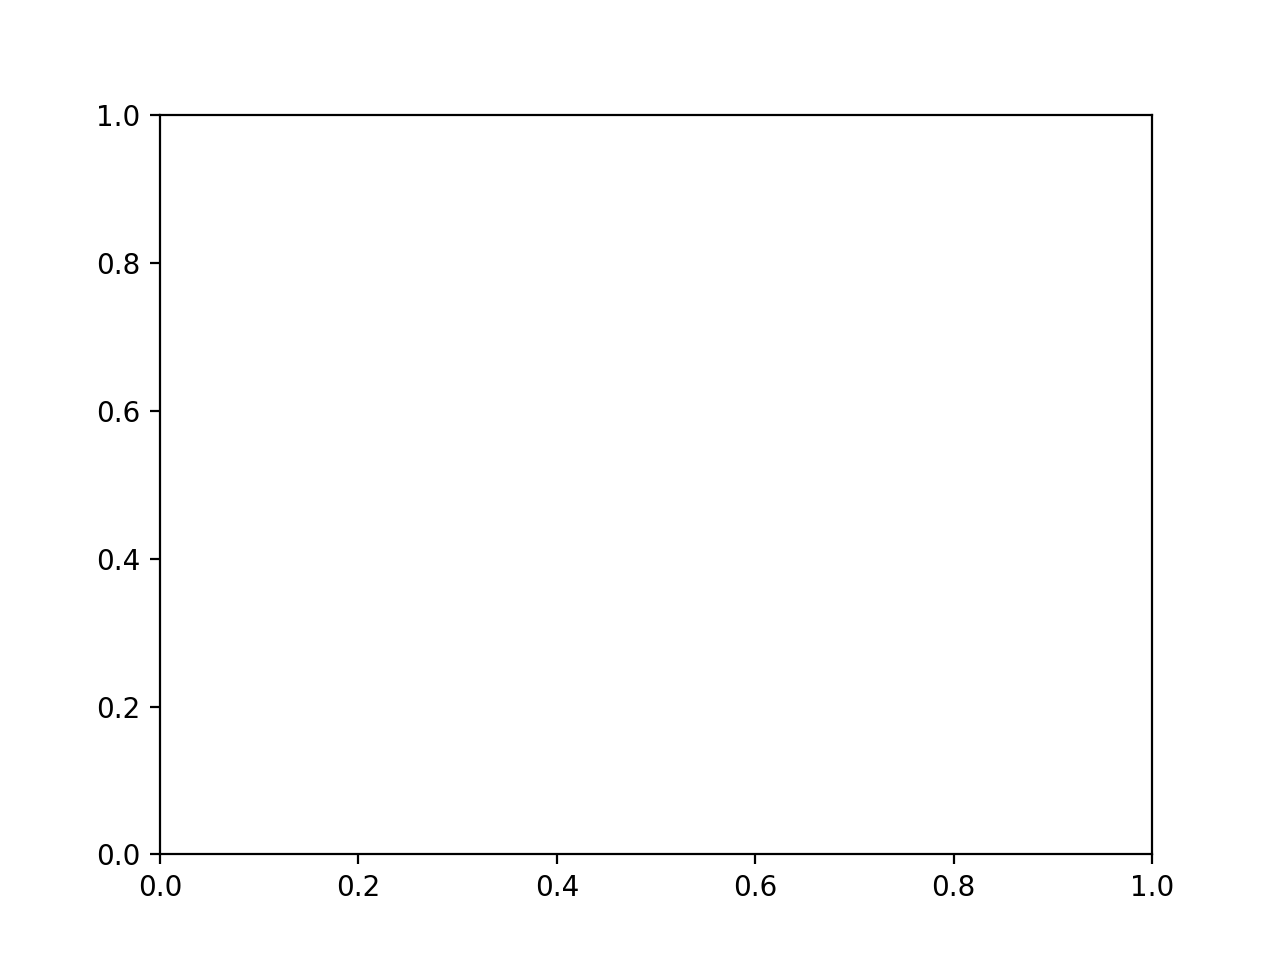

<IPython.core.display.Javascript object>


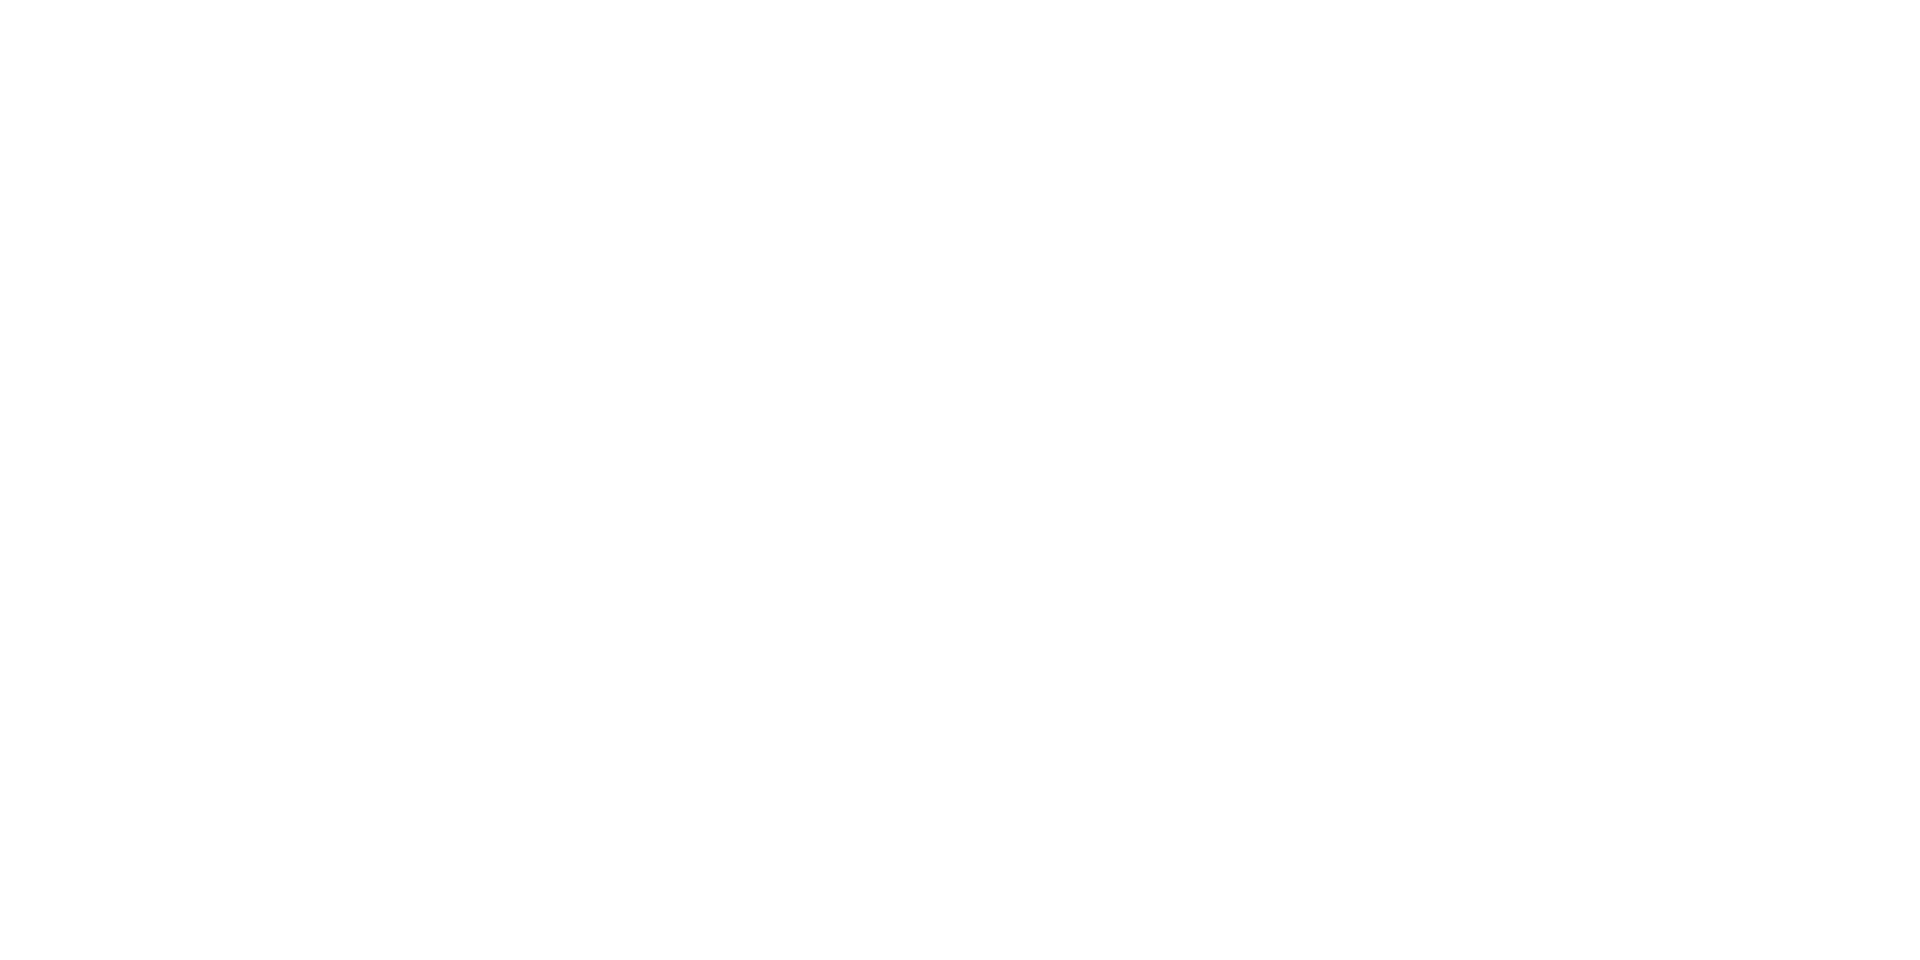

<IPython.core.display.Javascript object>


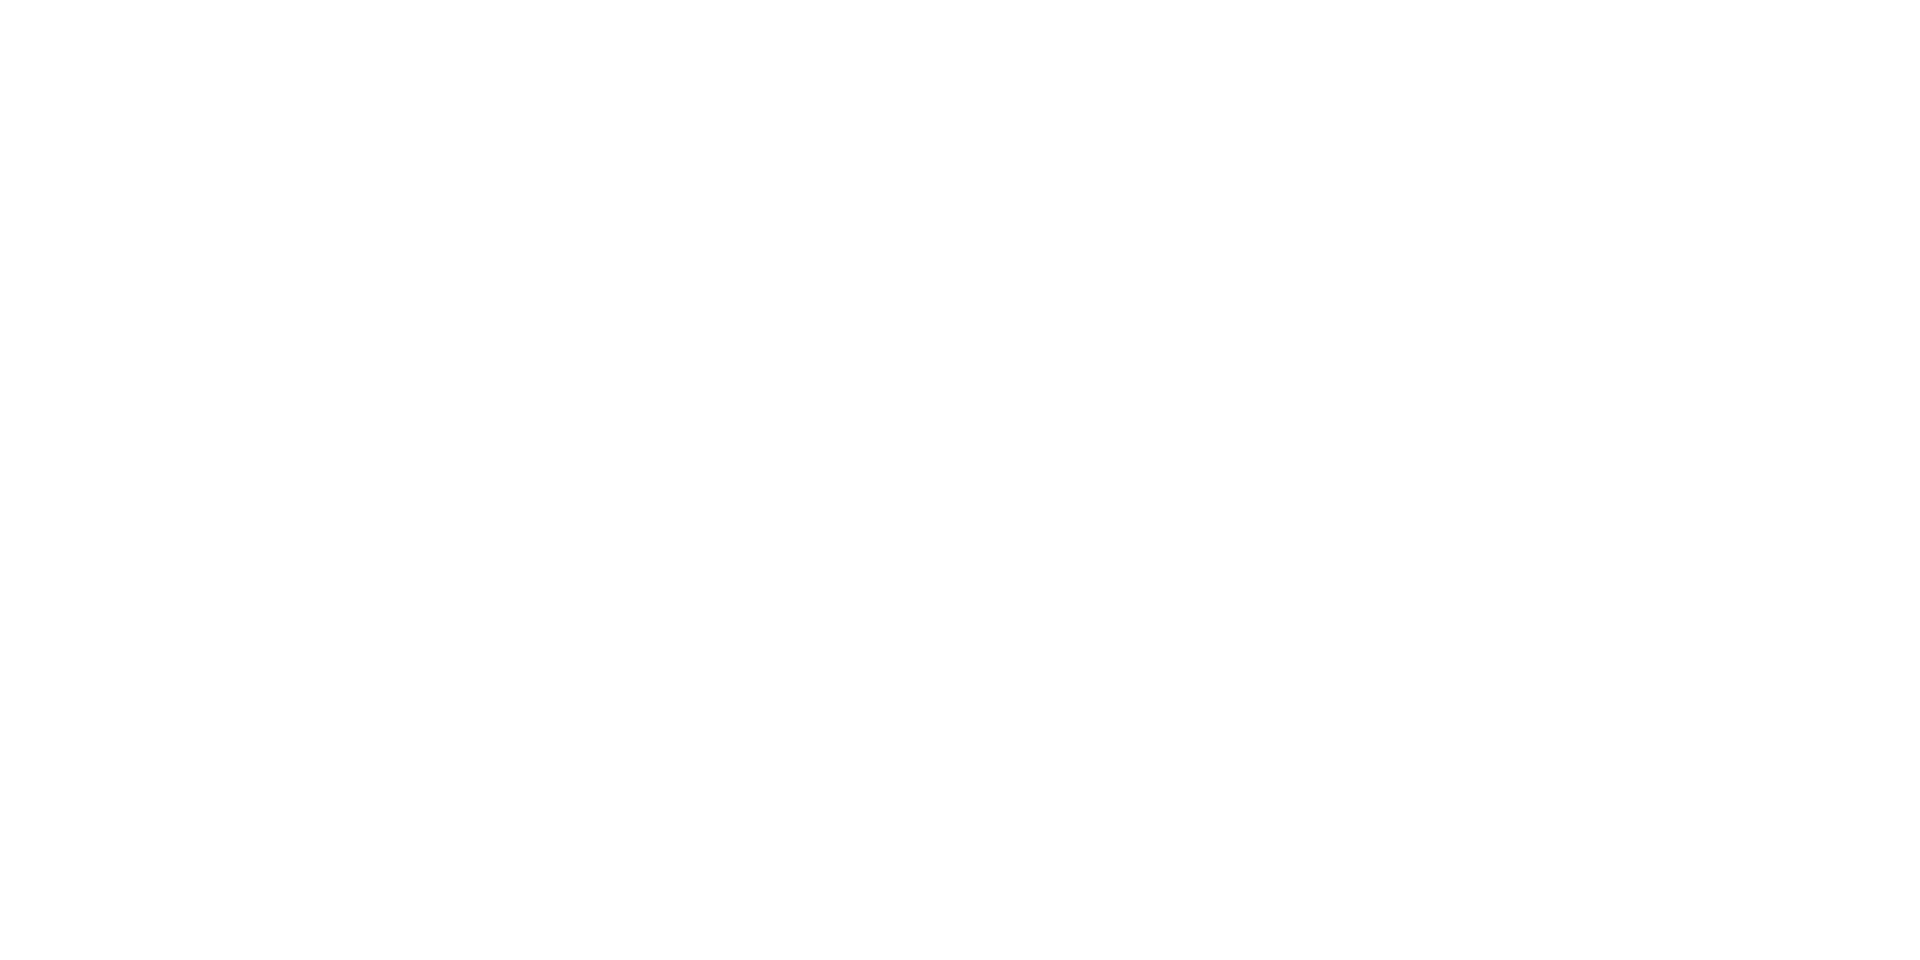

<IPython.core.display.Javascript object>


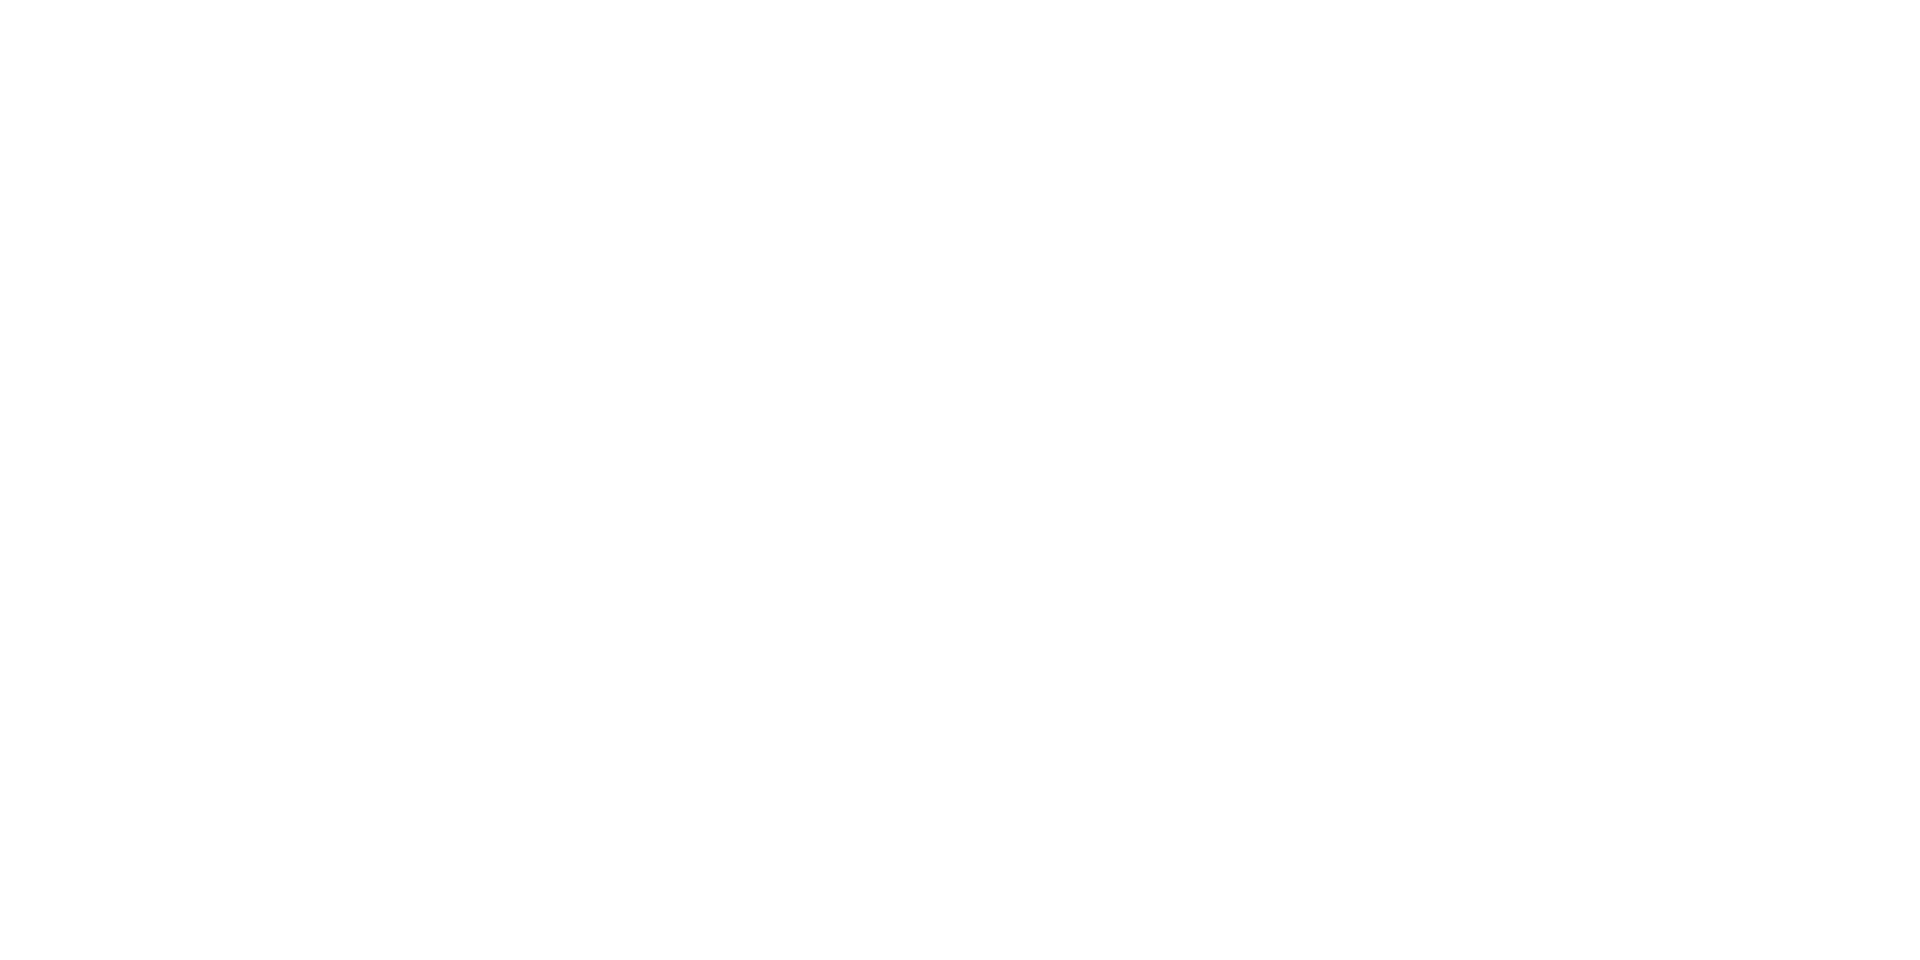

<IPython.core.display.Javascript object>


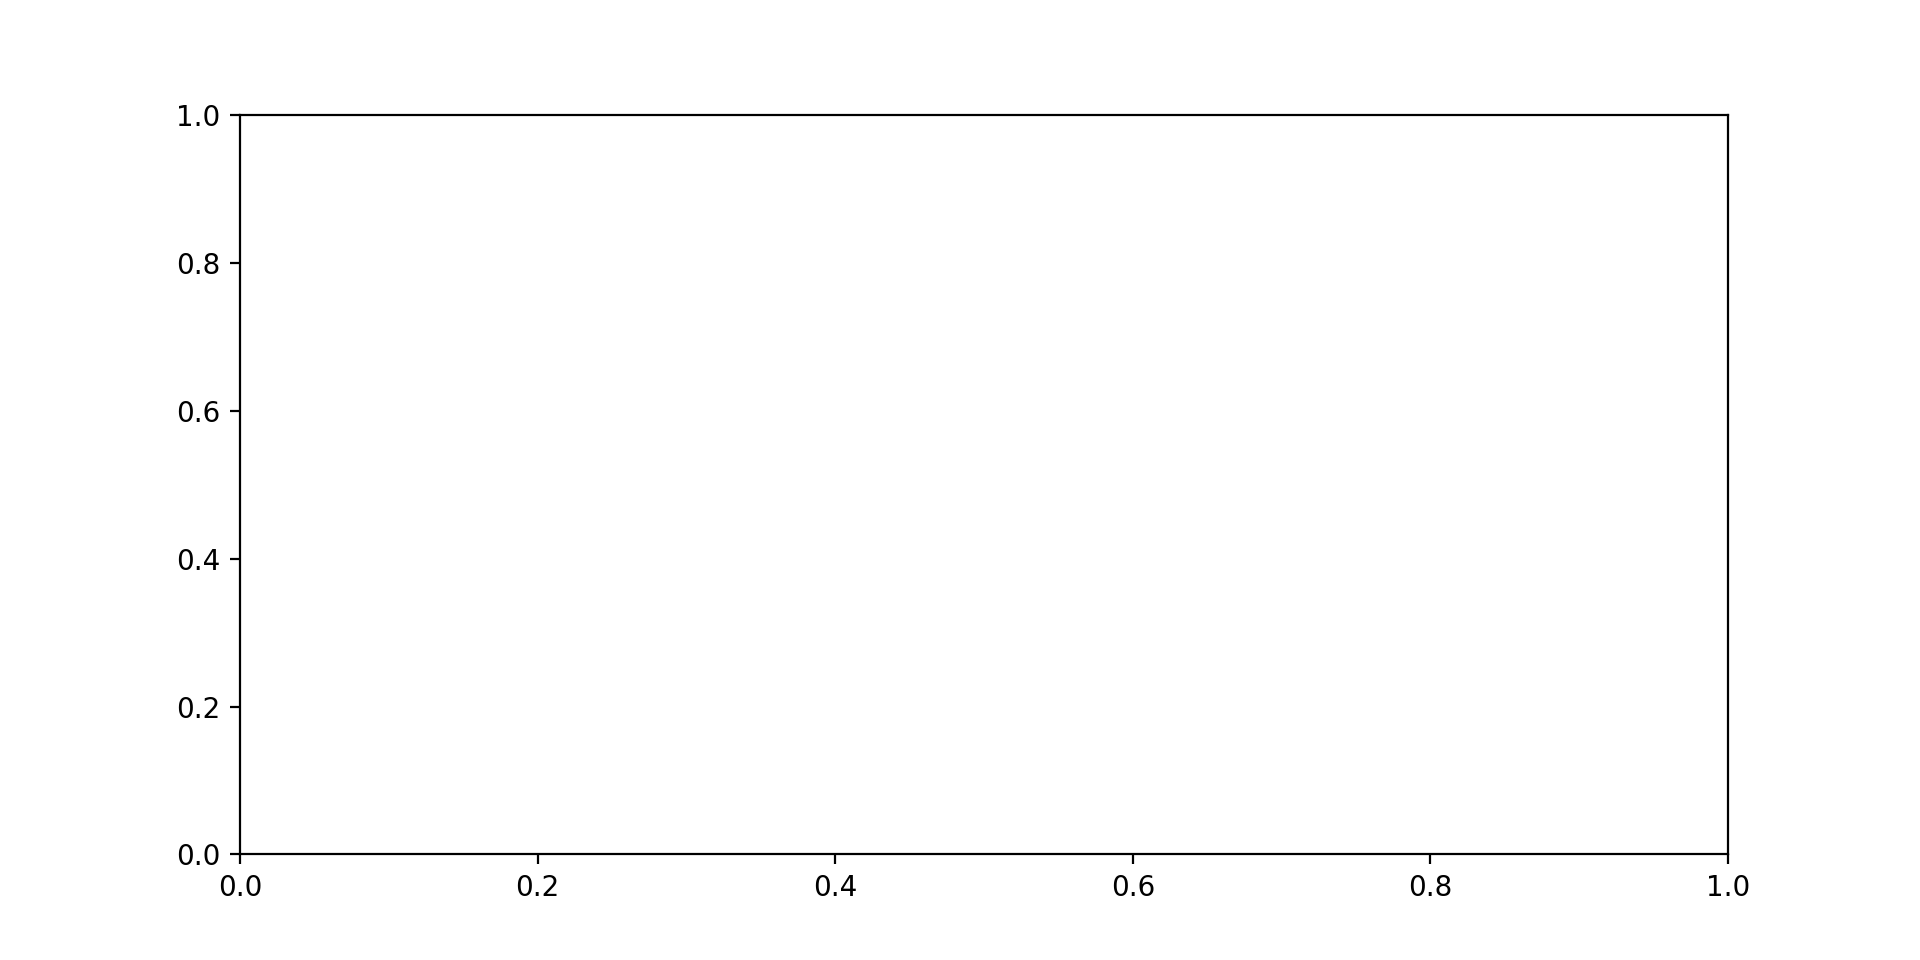

Lander Env
Landing_icgen:
    nominal_g                   :  -3.7114
    downrange                   :  (2000, 2000, -60, -60)
    crossrange                  :  (-1000, -1000, 30, 30)
    altitude                    :  (2400, 2400, -90, -90)
    adjust_apf_v0               :  True
Value Funtion
	xn_init: layer  Linear(in_features=6, out_features=60, bias=True)
	xn_init: layer  GRUCell(60, 17)
	xn_init: layer  Linear(in_features=17, out_features=5, bias=True)
	xn_init: layer  Linear(in_features=5, out_features=1, bias=True)
Value Function: recurrent steps > 1, disabling shuffle and batching
	Clip Range:         0.5
	Shuffle :           False
	Batch Size :        9999999
	Max Grad Norm:      30
	Recurrent Steps:    20
	Rollout Limit:      1
Agent


In [6]:
from env_killengine_test2 import Env
import env_utils as envu
from dynamics_model import Dynamics_model
from lander_model import Lander_model
from ic_gen2 import Landing_icgen
import rl_utils

from arch_policy_vf import Arch

from policy_drdv import Policy
from value_function import Value_function

import policy_nets as policy_nets
import valfunc_nets as valfunc_nets

from agent import Agent


import torch.nn as nn

from flat_constraint import Flat_constraint
from glideslope_constraint import Glideslope_constraint
from reward_terminal_mdr import Reward


logger = rl_utils.Logger()
dynamics_model = Dynamics_model()
lander_model = Lander_model(apf_tau1=20,apf_tau2=100,apf_vf1=-2,apf_vf2=-1,apf_v0=70,apf_atarg=15.)
lander_model.get_state_agent = lander_model.get_state_agent1
lander_model.max_thrust = 24000
lander_model.min_thrust = 4000
obs_dim = 6
act_dim = 3
recurrent_steps = 20

reward_object = Reward()

glideslope_constraint = Glideslope_constraint(gs_limit=-1.0)
shape_constraint = Flat_constraint()
env = Env(lander_model,dynamics_model,logger,
          reward_object=reward_object,
          kill_lateral_scale=2.,
          kill_vertical_scale=1.75,
          glideslope_constraint=glideslope_constraint,
          shape_constraint=shape_constraint,
          tf_limit=100.0,print_every=10,
          p_kill=1.0)

env.ic_gen = Landing_icgen(mass_uncertainty=0.0, 
                           g_uncertainty=(0.0,0.0),
                           adjust_apf_v0=True,
                          downrange = (2000,2000 , -60, -60), 
                           crossrange = (-1000,-1000 , 30,30),  
                           altitude = (2400,2400,-90,-90))
env.ic_gen.show()

arch = Arch()

policy = Policy(env)
value_function = Value_function(valfunc_nets.GRU(obs_dim, recurrent_steps=recurrent_steps), 
                                shuffle=False, batch_size=9999999, max_grad_norm=30)

agent = Agent(arch, policy, value_function, None, env, logger,
              policy_episodes=30, policy_steps=3000, gamma1=0.95, gamma2=0.995, lam=0.98, 
              recurrent_steps=recurrent_steps, monitor=env.rl_stats)
#agent.train(3)

# Test Policy 


Cumulative Stats (mean,std,max,argmax)
thrust   |10004.47 |2761.60 |5771.32 |13715.83 |     0
glideslope | 1.279 | 0.122 | 1.009 | 1.387 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |  67.978 |   0.000 |  67.978 |  67.978
norm_rf  |   375.1 |     0.0 |   375.1 |   375.1
position |   326.4  -184.8    -0.2 |     0.0     0.0     0.0 |   326.4  -184.8    -0.2 |   326.4  -184.8    -0.2
velocity | -43.930  18.986 -48.278 |   0.000   0.000   0.000 | -43.930  18.986 -48.278 | -43.930  18.986 -48.278
fuel     |143.39 |  0.00 |143.39 |143.39
glideslope |  1.01 |  0.00 |  1.01 |  1.01

Initial Stats (mean,std,min,max)
norm_vf  | 112.250 |   0.000 | 112.250 | 112.250
norm_rf  |  3280.2 |     0.0 |  3280.2 |  3280.2
position |  2000.0 -1000.0  2400.0 |     0.0     0.0     0.0 |  2000.0 -1000.0  2400.0 |  2000.0 -1000.0  2400.0
velocity | -60.000  30.000 -90.000 |   0.000   0.000   0.000 | -60.000  30.000 -90.000 | -60.000  30.000 -90.000
fue

<IPython.core.display.Javascript object>


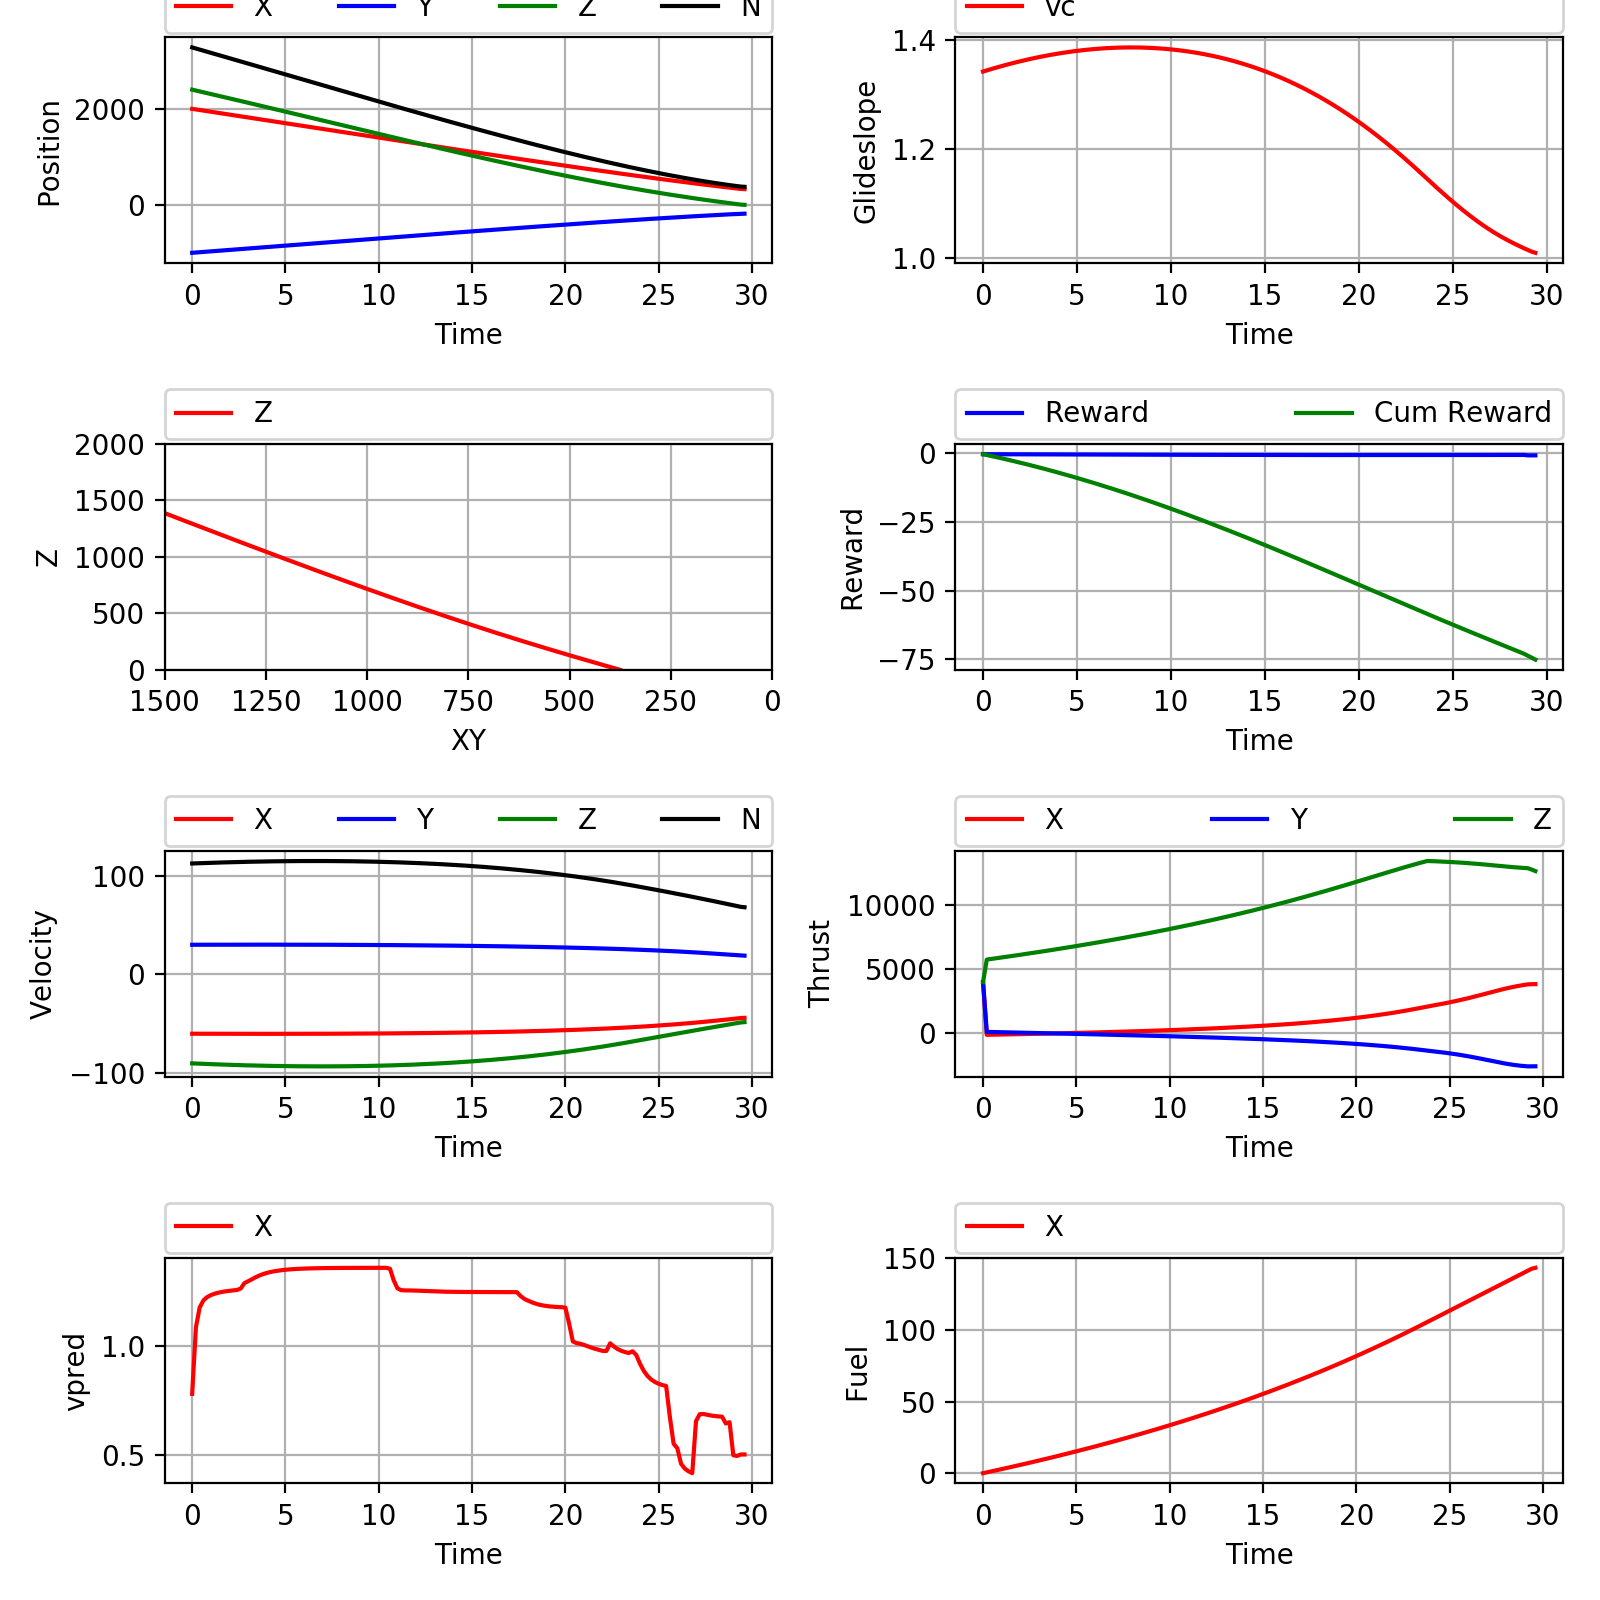

In [8]:
policy.test_mode=True
  
env.test_policy_batch(agent,1,print_every=1)
traj=lander_model.trajectory_list[0]
np.save('DRDV_fail.npy', traj)
envu.render_traj(traj)


Cumulative Stats (mean,std,max,argmax)
thrust   |10507.94 |452.80 |5325.26 |10813.75 |     0
glideslope | 1.063 | 0.154 | 0.905 | 1.608 |     0
sc_margin |100.000 | 0.000 |100.000 |100.000 |     0

Final Stats (mean,std,min,max)
norm_vf  |   0.465 |   0.000 |   0.465 |   0.465
norm_rf  |     0.0 |     0.0 |     0.0 |     0.0
position |    -0.0     0.0    -0.0 |     0.0     0.0     0.0 |    -0.0     0.0    -0.0 |    -0.0     0.0    -0.0
velocity |  -0.148   0.074  -0.435 |   0.000   0.000   0.000 |  -0.148   0.074  -0.435 |  -0.148   0.074  -0.435
fuel     |264.30 |  0.00 |264.30 |264.30
glideslope |  1.61 |  0.00 |  1.61 |  1.61

Initial Stats (mean,std,min,max)
norm_vf  | 112.250 |   0.000 | 112.250 | 112.250
norm_rf  |  3280.2 |     0.0 |  3280.2 |  3280.2
position |  2000.0 -1000.0  2400.0 |     0.0     0.0     0.0 |  2000.0 -1000.0  2400.0 |  2000.0 -1000.0  2400.0
velocity | -60.000  30.000 -90.000 |   0.000   0.000   0.000 | -60.000  30.000 -90.000 | -60.000  30.000 -90.000
fuel

<IPython.core.display.Javascript object>


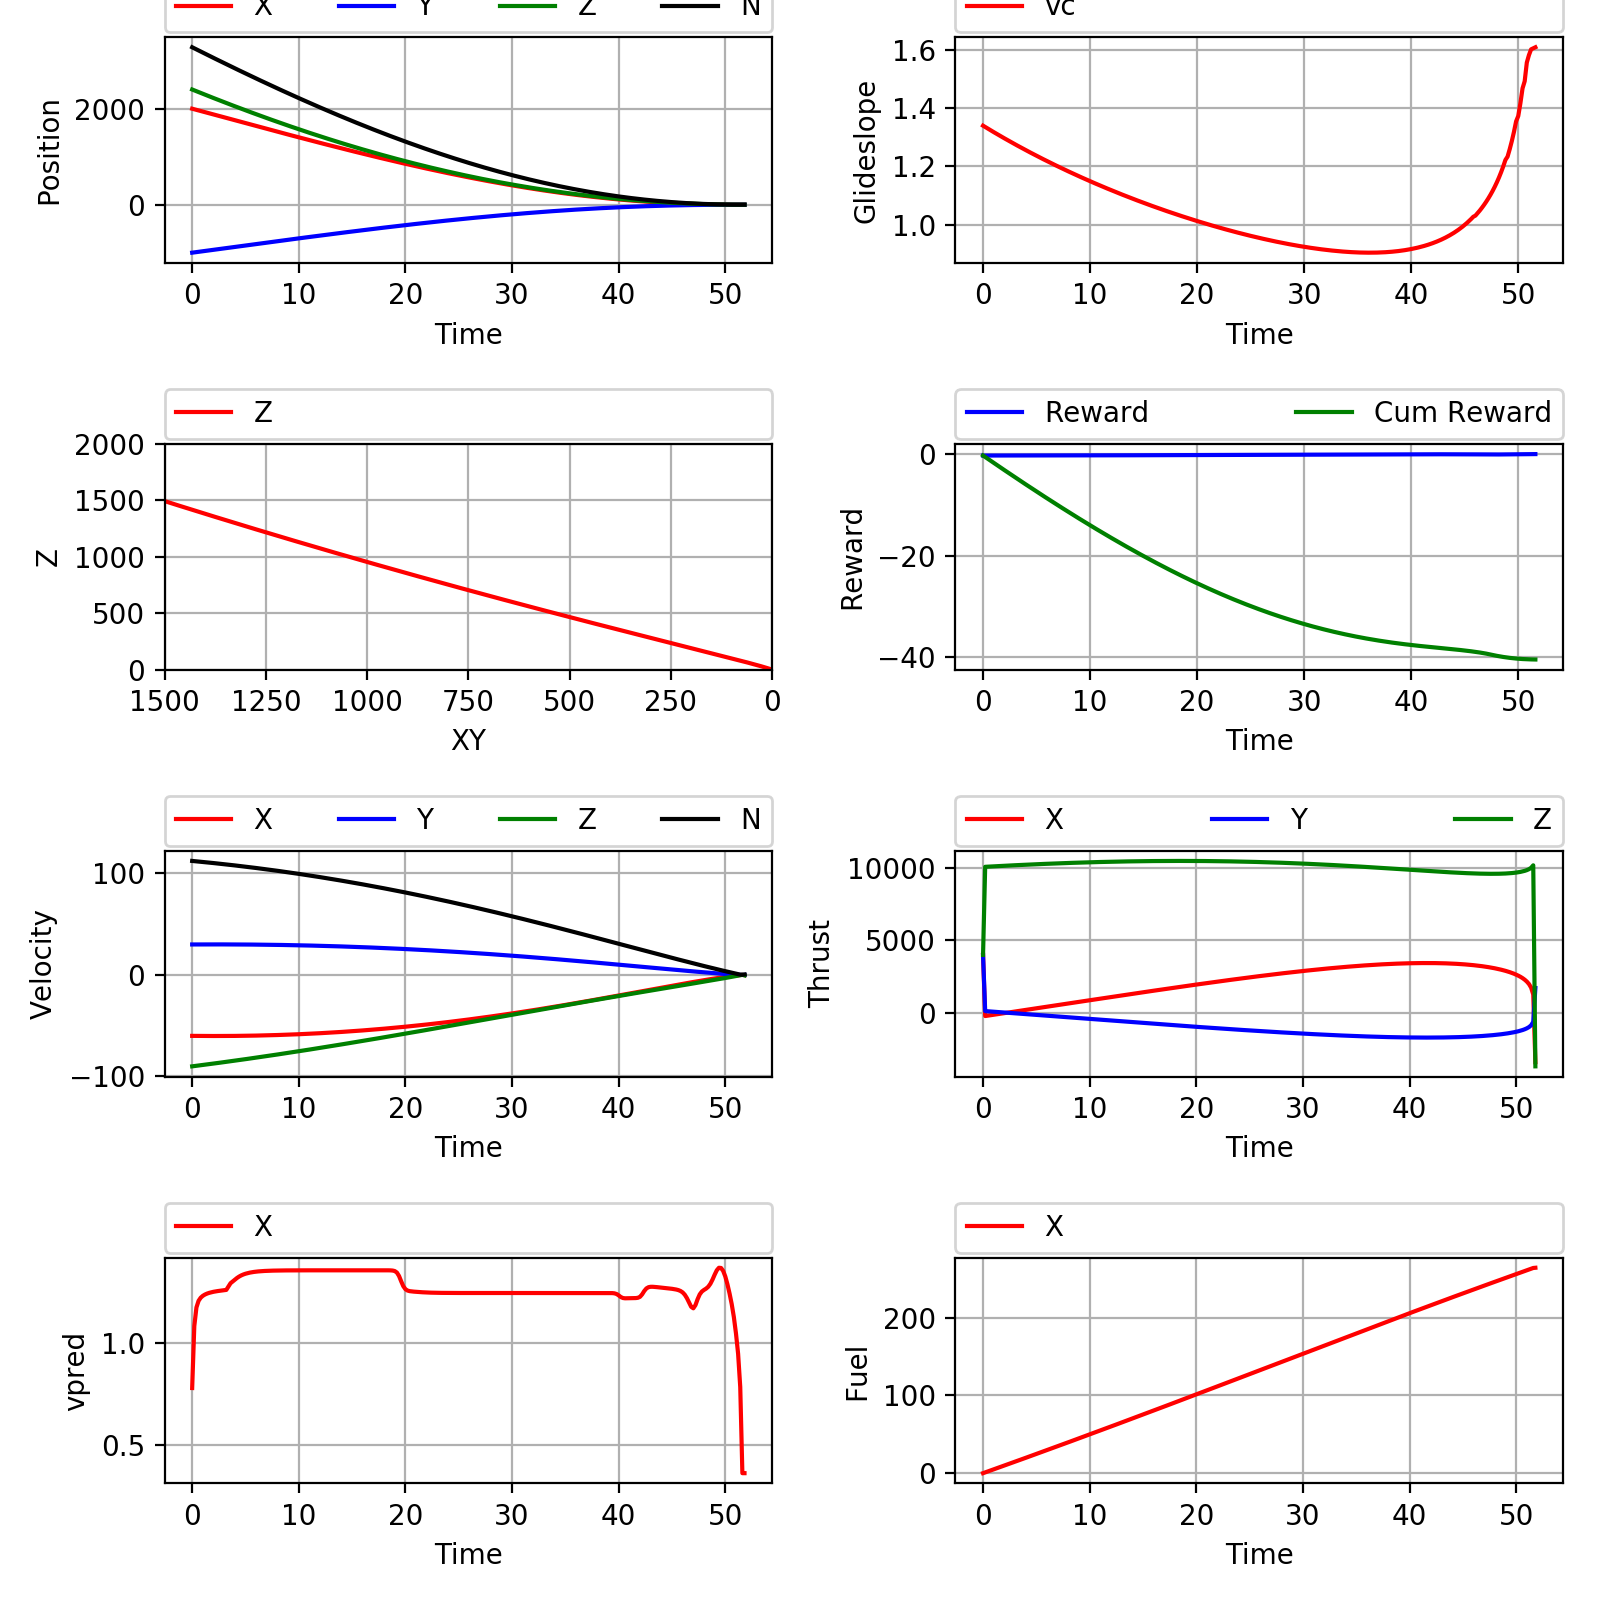

In [10]:
policy.test_mode=True
  
env.test_policy_batch(agent,1,print_every=1)
env.p_kill = 0.0
traj=lander_model.trajectory_list[0]
np.save('DRDV_nofail.npy', traj)
envu.render_traj(traj)